# 남성 톤 분류를 위한 모델 생성 코드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# 학습에 사용할 데이터 불러오기

In [ ]:
image_dir = Path('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Tone/man')

In [ ]:
image_dir

PosixPath('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Season/man')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [ ]:
images

,Filepath,Label
0,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
1,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
2,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
3,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
4,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
...,...,...
446,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel
447,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel
448,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel
449,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel


In [ ]:
images.Label.value_counts()

neutral    145
mono       144
toneon     104
pastel      58
Name: Label, dtype: int64

# Train / Test Split & 모델 신경망 구축 by Resnet50 with pretrained layer 호출

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 252 validated image filenames belonging to 4 classes.
Found 63 validated image filenames belonging to 4 classes.
Found 136 validated image filenames belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 모델 학습 with Early Stopping / Epoch : 25


In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=25,callbacks=[callbacks])


Epoch 1/25
8/8 [==============================] - 122s 15s/step - loss: 1.3779 - accuracy: 0.3849 - val_loss: 1.3135 - val_accuracy: 0.4762
Epoch 2/25
8/8 [==============================] - 45s 6s/step - loss: 1.0072 - accuracy: 0.6190 - val_loss: 0.9374 - val_accuracy: 0.5397
Epoch 3/25
8/8 [==============================] - 45s 6s/step - loss: 0.8200 - accuracy: 0.7222 - val_loss: 0.9152 - val_accuracy: 0.6349
Epoch 4/25
8/8 [==============================] - 47s 6s/step - loss: 0.7189 - accuracy: 0.6984 - val_loss: 0.9249 - val_accuracy: 0.5397
Epoch 5/25
8/8 [==============================] - 47s 6s/step - loss: 0.5866 - accuracy: 0.7619 - val_loss: 0.9180 - val_accuracy: 0.5714
Epoch 6/25
8/8 [==============================] - 45s 6s/step - loss: 0.5195 - accuracy: 0.8135 - val_loss: 0.7865 - val_accuracy: 0.6508
Epoch 7/25
8/8 [==============================] - 45s 6s/step - loss: 0.4000 - accuracy: 0.8571 - val_loss: 0.8499 - val_accuracy: 0.5238
Epoch 8/25
8/8 [================

In [ ]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.8770846128463745, 0.6397058963775635]
Test Accuracy: 63.97%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

5/5 [==============================] - 21s 4s/step


In [ ]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [ ]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        mono       0.74      0.88      0.80        48
     neutral       0.62      0.65      0.63        40
      pastel       0.53      0.53      0.53        17
      toneon       0.50      0.32      0.39        31

    accuracy                           0.64       136
   macro avg       0.60      0.59      0.59       136
weighted avg       0.62      0.64      0.62       136



In [ ]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,1.377941,0.384921,1.313497,0.476190
1,1.007216,0.619048,0.937378,0.539683
2,0.820031,0.722222,0.915173,0.634921
3,0.718864,0.698413,0.924863,0.539683
4,0.586555,0.761905,0.918037,0.571429
5,0.519527,0.813492,0.786469,0.650794
6,0.399999,0.857143,0.849865,0.523810
7,0.354898,0.912698,0.782387,0.619048
8,0.279422,0.924603,0.866325,0.603175
9,0.292615,0.908730,0.971240,0.571429


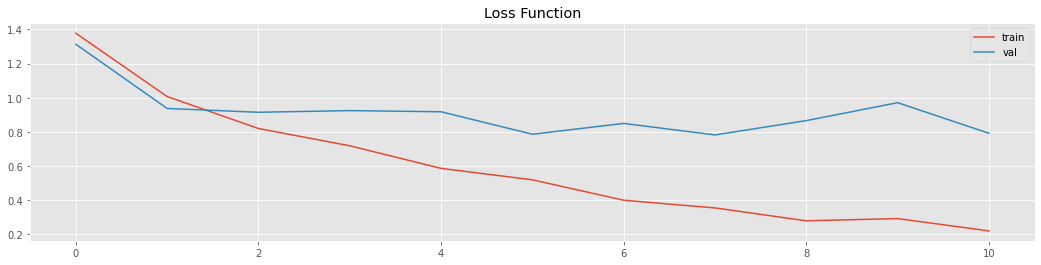

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)


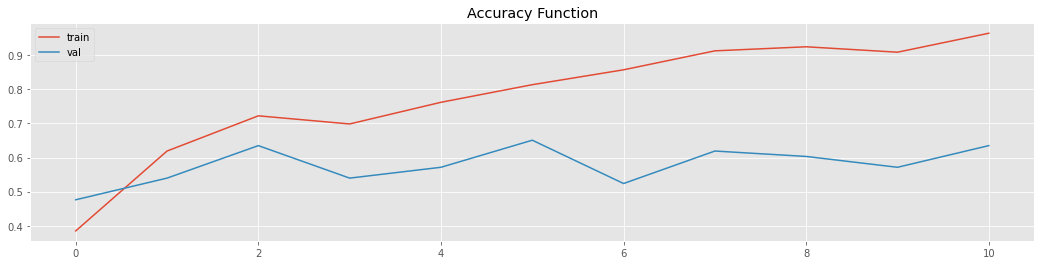

In [ ]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [ ]:
train_images.class_indices.keys()

dict_keys(['mono', 'neutral', 'pastel', 'toneon'])

In [ ]:
train_images.class_indices.values()

dict_values([0, 1, 2, 3])

In [ ]:
model.save("/content/drive/MyDrive/2023 KUIAI 해커톤/man_tone_tag_classificator.h5")

# 모델 학습 결과 확인

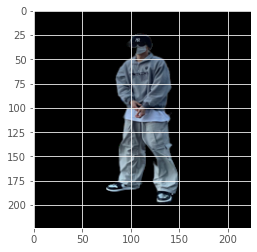

1/1 [==============================] - 0s 186ms/step
[0]


In [ ]:
from tensorflow.keras.preprocessing import image
dir_path = '/content/drive/MyDrive/2023 KUIAI 해커톤/influ_man_half/@dbs.ycaa_1_half.png'

img = image.load_img(dir_path, target_size=(224,224))
plt.imshow(img)
plt.show()
    
X = image.img_to_array(img)
X = np.expand_dims(X,axis=0)
images = np.vstack([X])
predictions = np.argmax(model.predict(images), axis=1)
print(predictions)